In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings=False
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score as r2

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
data = df.copy()

In [4]:
def dummies(df,features):
    df[features]=df[features].astype(object)
    df=pd.get_dummies(df)
    return df

In [5]:
data= dummies(data, ['Ecology_2', 'Ecology_3', 'Shops_2'] )

In [6]:
feats = data.columns 

In [7]:
#корреляцию признаков на тренировочном фрейме без обработки данных
for i in feats:
    corr_f = data.loc[:, ['Price',i]].corr()
    print(corr_f) 

         Price       Id
Price  1.00000  0.00988
Id     0.00988  1.00000
             Price  DistrictId
Price       1.0000      0.2651
DistrictId  0.2651      1.0000
          Price     Rooms
Price  1.000000  0.550291
Rooms  0.550291  1.000000
           Price    Square
Price   1.000000  0.520075
Square  0.520075  1.000000
               Price  LifeSquare
Price       1.000000    0.081292
LifeSquare  0.081292    1.000000
                  Price  KitchenSquare
Price          1.000000       0.028864
KitchenSquare  0.028864       1.000000
          Price     Floor
Price  1.000000  0.128715
Floor  0.128715  1.000000
              Price  HouseFloor
Price       1.00000     0.08828
HouseFloor  0.08828     1.00000
              Price  HouseYear
Price      1.000000   0.004305
HouseYear  0.004305   1.000000
              Price  Ecology_1
Price      1.000000  -0.058381
Ecology_1 -0.058381   1.000000
             Price  Social_1
Price     1.000000  0.263286
Social_1  0.263286  1.000000
             

In [8]:
#Ковариация
for i in feats:
    x = data.loc[:, ['Price', i]]
    xT=x.T
    i_cov=np.cov(xT)
    print(i, i_cov)
    #из показателей ковариации в принципе можно сделать вывод, что на тренировочном датафрейме нет линейной зависимости
# или она есть у не большого количества признаков и очень слабая!!!

Id [[8.62526297e+09 4.45864686e+06]
 [4.45864686e+06 2.36100658e+07]]
DistrictId [[8.62526297e+09 1.07314763e+06]
 [1.07314763e+06 1.89987815e+03]]
Rooms [[8.62526297e+09 4.29047349e+04]
 [4.29047349e+04 7.04780228e-01]]
Square [[8.62526297e+09 1.01714753e+06]
 [1.01714753e+06 4.43470184e+02]]
LifeSquare [[8.62526297e+09            nan]
 [           nan            nan]]
KitchenSquare [[8.62526297e+09 7.65626874e+04]
 [7.65626874e+04 8.15725980e+02]]
Floor [[8.62526297e+09 6.26531286e+04]
 [6.26531286e+04 2.74696341e+01]]
HouseFloor [[8.62526297e+09 5.55544835e+04]
 [5.55544835e+04 4.59138230e+01]]
HouseYear [[8.62526297e+09 8.01704035e+07]
 [8.01704035e+07 4.02003548e+10]]
Ecology_1 [[ 8.62526297e+09 -6.45349432e+02]
 [-6.45349432e+02  1.41670133e-02]]
Social_1 [[8.62526297e+09 4.28706832e+05]
 [4.28706832e+05 3.07392570e+02]]
Social_2 [[8.62526297e+09 8.90207947e+07]
 [8.90207947e+07 1.60544447e+07]]
Social_3 [[8.62526297e+09 1.65728515e+05]
 [1.65728515e+05 5.67958259e+02]]
Healthcar

In [9]:
#Интересно, что наиболее статистически коррелируют, больше 0,1, такие признаки как:
#Rooms = 0.550291
#Square = 0.520075
#Floor =  0.128715
#Social_1 = 0.263286
#Social_2 = 0.239226
#Healthcare_1 = 0.138755
#Helthcare_2 = 0.25309
#Shops_1 = 0.180876

#Так как линейной зависимости нет, что показал коеффициент ковариации, а статистическая зависимость
# сколько менее значемых признаков, согласно коэффициенту корреляции от Price, показанна выше!

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Shops_2_B        10000 non-null uint8
dtyp

In [11]:
#Заполняю пропуски Healthcare_1 так как признак имеет корреляцию больше 0.1
#data['Healthcare_1']=data['Healthcare_1'].fillna(data['Healthcare_1'].mean())
data['Healthcare_1']=data['Healthcare_1'].fillna(data['Healthcare_1'].median())

In [12]:
#data.loc[:,['Price','Healthcare_1']].corr() #уменьшилась на 0.03
data.loc[:,['Price','Healthcare_1']].corr() #медиана лучше уменьшилась на 0.01

,Price,Healthcare_1
Price,1.000000,0.128059
Healthcare_1,0.128059,1.000000


In [13]:
#Заполняю LifeSquare
#square_lifesquare=(data.Square/data.LifeSquare).median()
#data['LifeSquare']=data.LifeSquare.fillna(data['Square']/square_lifesquare)
square_lifesquare=(data.Square/data.LifeSquare).mean()
data['LifeSquare']=data.LifeSquare.fillna(data['Square']/square_lifesquare)

In [14]:
#data.loc[:,['Price','LifeSquare']].corr() 0.091258
data.loc[:,['Price','LifeSquare']].corr()

,Price,LifeSquare
Price,1.000000,0.096153
LifeSquare,0.096153,1.000000


In [15]:
data.loc[data.Rooms>5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,...,900.0,5,15,317265.323792,0,1,0,1,0,1
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,...,900.0,0,1,78364.616704,0,1,0,1,0,1
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,...,1322.0,3,8,229661.964416,0,1,0,1,0,1
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,...,30.0,2,4,172329.270863,0,1,0,1,0,1


In [16]:
data.loc[data.Rooms==19,'Rooms']=1
data.loc[data.Rooms==10,'Rooms']=2

In [17]:
data.loc[data.Rooms==6,'Rooms']=2

In [18]:
data.loc[(data.Rooms>4)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
1422,4282,195,5.0,95.617533,62.377052,7.0,7,7.0,1940,0.015017,...,2890.0,0,8,479525.147323,0,1,0,1,0,1
1503,1243,86,5.0,108.057398,82.723825,8.0,3,5.0,1942,0.161976,...,4508.0,3,7,310305.074733,0,1,1,0,0,1
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,...,4508.0,3,7,455264.882666,0,1,1,0,0,1
3268,8901,34,5.0,121.577423,114.913843,1.0,25,1.0,1977,0.069753,...,900.0,1,11,455446.393758,0,1,0,1,0,1
3271,6358,27,5.0,42.003293,19.761545,0.0,5,12.0,1977,0.011654,...,900.0,0,0,112693.641769,0,1,0,1,0,1
4431,7594,53,5.0,39.906082,39.394024,1.0,5,1.0,1977,0.049637,...,229.0,1,3,206148.845716,0,1,0,1,0,1
4487,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,...,900.0,5,15,622888.825328,0,1,0,1,0,1
4762,4070,21,5.0,114.313752,88.492650,9.0,6,5.0,1960,0.034331,...,900.0,0,4,499830.937577,0,1,0,1,0,1
5361,2879,78,5.0,118.871952,69.023509,10.0,15,16.0,1998,0.092291,...,165.0,1,2,496026.671162,0,1,0,1,0,1
5466,3454,8,5.0,112.135525,79.795451,10.0,4,17.0,1999,0.437885,...,1084.0,0,5,471833.787538,0,1,0,1,0,1


In [19]:
data.loc[3271,'Rooms']=1
data.loc[4431,'Rooms']=1

In [20]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.885900,56.315775,35.339113,6.273300,8.526700,12.609400,3.990166e+03,0.118858,...,1026.358900,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.811756,21.058732,76.832032,28.560917,5.241148,6.775974,2.005003e+05,0.119025,...,746.662828,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.360510,1.000000,4.000000,9.000000,1.974000e+03,0.017647,...,830.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513310,31.295038,6.000000,7.000000,13.000000,1.977000e+03,0.075424,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,65.900625,42.165321,9.000000,12.000000,17.000000,2.001000e+03,0.195781,...,990.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,5.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
data.loc[data.Rooms == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,...,900.0,0,0,268394.744389,0,1,0,1,0,1
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,900.0,0,1,302211.260887,0,1,0,1,0,1
2269,7317,27,0.0,41.790881,19.661610,0.0,13,0.0,1977,0.211401,...,900.0,0,1,98129.976788,0,1,0,1,0,1
3911,770,28,0.0,49.483501,23.280804,0.0,16,0.0,2015,0.118537,...,1183.0,1,0,217009.338463,0,1,0,1,0,1
4366,456,6,0.0,81.491446,38.339777,0.0,4,0.0,1977,0.243205,...,540.0,0,0,212864.799112,0,1,0,1,0,1
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,...,900.0,0,0,126596.941798,0,1,0,1,0,1
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,...,900.0,3,9,158998.110646,0,1,0,1,0,1
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,...,900.0,0,1,219281.918007,0,1,0,1,0,1


In [22]:
data.loc[2269,'Rooms']=1
data.loc[3911,'Rooms']=1
data.loc[6149,'Rooms']=1
data.loc[1397,'Rooms']=5
data.loc[1981,'Rooms']=5
data.loc[4366,'Rooms']=3
data.loc[8834,'Rooms']=3

In [23]:
data = data.drop(data.loc[data.Rooms == 0].index)

In [24]:
data=data.reset_index(drop=True)

In [25]:
data.loc[data.LifeSquare>data.Square.max()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,...,900.0,0,0,217357.492366,0,1,0,1,0,1


In [26]:
data.loc[4328,'LifeSquare']=data.loc[4328,'LifeSquare']/100

In [27]:
#индекс больших кухонь
index_kit = data.loc[data.KitchenSquare>30].index  

In [28]:
for i in index_kit:
    data.loc[i, 'KitchenSquare'] = data.loc[i,'KitchenSquare']/10

In [29]:
data = data.drop(data.loc[data.KitchenSquare>100].index)

In [30]:
#index LifeSquare <10
index_ls = data.loc[data.LifeSquare < 10].index  
data.loc[data.LifeSquare < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,...,900.0,0,0,337299.867936,0,1,0,1,1,0
95,4280,34,2.0,61.334968,4.091945,1.0,26,1.0,2014,0.069753,...,900.0,1,11,286564.441972,0,1,0,1,0,1
134,12613,6,2.0,65.496674,5.589324,1.0,5,17.0,1977,0.243205,...,540.0,0,0,180727.643541,0,1,0,1,0,1
158,16779,27,3.0,51.991064,4.896202,1.0,22,25.0,1977,0.072158,...,900.0,0,0,174687.566186,0,1,0,1,1,0
160,3522,6,1.0,66.419841,3.987101,1.0,2,1.0,1977,0.243205,...,540.0,0,0,193361.229815,0,1,0,1,0,1
270,15215,17,1.0,46.692974,5.941401,1.0,7,1.0,2015,0.000000,...,620.0,1,2,212290.684086,0,1,0,1,0,1
279,8727,1,2.0,79.521221,4.634049,1.0,5,1.0,2017,0.007122,...,900.0,0,1,232726.628137,0,1,0,1,0,1
363,15751,9,1.0,44.171793,1.251846,1.0,11,18.0,2017,0.161532,...,30.0,2,4,134910.715588,0,1,0,1,0,1
475,6333,27,2.0,64.049695,4.008230,1.0,5,5.0,2017,0.017647,...,900.0,0,0,189477.560210,0,1,0,1,0,1
477,8849,45,1.0,63.419553,2.286357,1.0,3,1.0,1977,0.195781,...,900.0,3,2,325600.765809,0,1,0,1,0,1


In [31]:
for i in index_ls:
    data.loc[i, 'LifeSquare'] = data.loc[i, 'Square'] - (data.KitchenSquare.mean())

In [32]:
data.loc[data.LifeSquare < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
1316,11526,27,1.0,4.633498,-1.065091,1.0,18,1.0,1977,0.011654,...,900.0,0,0,107604.269441,0,1,0,1,0,1
1608,10202,6,1.0,2.596351,-3.102238,1.0,3,25.0,2014,0.243205,...,540.0,0,0,137597.601458,0,1,0,1,0,1
3413,9487,5,1.0,5.129222,-0.569368,1.0,1,1.0,1977,0.150818,...,2643.0,4,5,369472.403061,0,1,0,1,0,1
4899,4504,27,3.0,4.390331,-1.308259,1.0,8,19.0,2016,0.211401,...,900.0,0,1,161379.067034,0,1,0,1,0,1
6391,14786,1,1.0,1.136859,-4.561731,1.0,3,1.0,1977,0.007122,...,900.0,0,1,181434.825589,0,1,0,1,0,1
8282,15744,34,1.0,1.988943,-3.709647,1.0,21,4.0,1977,0.069753,...,900.0,1,11,458378.777006,0,1,0,1,0,1
9293,6782,45,1.0,2.954309,-2.744281,1.0,3,1.0,1977,0.195781,...,900.0,3,2,438005.182323,0,1,0,1,0,1
9612,7657,38,1.0,4.502784,-1.195806,1.0,28,1.0,1977,0.060753,...,520.0,0,7,483283.488083,0,1,0,1,0,1


In [33]:
data = data.drop(data.loc[data.LifeSquare < 10].index)
data=data.reset_index(drop=True)

In [34]:
#index KitchenSqure = 0
index_K = data.loc[data.KitchenSquare == 0].index

In [35]:
for i in index_K:
    data.loc[i, 'KitchenSquare'] = data.loc[i, 'KitchenSquare'] + (data.KitchenSquare.mean())

In [36]:
data=data.drop(data.loc[data.Square<15].index)
data=data.reset_index(drop=True)

In [37]:
data.loc[data.LifeSquare>data.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
28,8054,23,1.0,42.530043,43.967759,1.000000,3,9.0,2014,0.034656,...,900.0,0,0,95338.198549,0,1,0,1,0,1
44,10521,38,3.0,104.211396,106.340403,5.705779,20,0.0,2017,0.060753,...,520.0,0,7,435462.048070,0,1,0,1,0,1
52,2301,1,2.0,61.400054,65.224603,5.706350,17,22.0,2016,0.007122,...,900.0,0,1,199215.452229,0,1,0,1,0,1
123,8753,25,3.0,85.952306,89.803753,1.000000,4,3.0,2017,0.069753,...,900.0,1,11,309688.592681,0,1,0,1,0,1
153,9870,62,1.0,51.831473,53.491301,1.000000,5,1.0,2015,0.072158,...,900.0,0,0,131797.472284,0,1,0,1,1,0
178,2416,57,1.0,29.298168,29.770784,5.000000,7,5.0,1964,0.133215,...,1406.0,3,4,148991.265200,0,1,0,1,1,0
184,3398,74,1.0,48.743665,51.011232,1.000000,12,20.0,2017,0.075779,...,900.0,0,2,165071.825722,0,1,0,1,0,1
216,5540,27,3.0,57.643613,59.425078,9.000000,16,10.0,1977,0.072158,...,900.0,0,0,198351.892455,0,1,0,1,1,0
233,12633,27,3.0,81.867166,81.884548,5.712065,12,19.0,1977,0.211401,...,900.0,0,1,182228.520030,0,1,0,1,0,1
235,3916,1,1.0,43.084413,47.071617,1.000000,9,7.0,2017,0.007122,...,900.0,0,1,169749.173815,0,1,0,1,0,1


In [38]:
data.loc[data.Floor>data.HouseFloor,'HouseFloor']=data.loc[data.Floor>data.HouseFloor,'Floor']

In [39]:
data.loc[data.LifeSquare>data.Square,'Square'] = data.loc[data.LifeSquare>data.Square,'LifeSquare']

In [40]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9.985000e+03,9985.000000,...,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000,9985.000000
mean,8380.832649,50.421432,1.888533,56.536059,35.618207,6.114766,8.525488,13.436655,3.993177e+03,0.118865,...,1026.277817,1.319279,4.232449,214109.641171,0.009715,0.990285,0.027541,0.972459,0.082524,0.917476
std,4859.327085,43.603120,0.811386,21.517346,18.783239,3.614394,5.234330,6.087620,2.006508e+05,0.119053,...,746.770115,1.492574,4.807737,92764.057346,0.098088,0.098088,0.163663,0.163663,0.275175,0.275175
min,0.000000,0.000000,1.000000,16.117154,10.418565,1.000000,1.000000,1.000000,1.910000e+03,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4167.000000,20.000000,1.000000,41.884130,22.719419,4.000000,4.000000,9.000000,1.974000e+03,0.017647,...,830.000000,0.000000,1.000000,153918.528247,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8392.000000,36.000000,2.000000,52.676642,31.766993,6.000000,7.000000,14.000000,1.977000e+03,0.075424,...,900.000000,1.000000,3.000000,192302.751941,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12590.000000,75.000000,2.000000,66.008793,43.124871,9.000000,12.000000,17.000000,2.001000e+03,0.195781,...,990.000000,2.000000,6.000000,249114.537525,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.000000,209.000000,5.000000,641.065193,638.163193,30.000000,42.000000,117.000000,2.005201e+07,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
data.loc[data.Square>200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
589,14990,23,2.0,263.542020,263.542020,5.000000,6,6.0,1972,0.075779,...,900.0,0,2,141780.231857,0,1,0,1,0,1
1977,7917,27,5.0,212.932361,211.231125,5.781096,2,3.0,2008,0.211401,...,900.0,0,1,302211.260887,0,1,0,1,0,1
1978,5548,86,5.0,275.645284,233.949309,26.000000,12,37.0,2011,0.161976,...,4508.0,3,7,455264.882666,0,1,1,0,0,1
4256,28,9,2.0,604.705972,284.499700,1.000000,17,18.0,1977,0.161532,...,30.0,2,4,187717.242538,0,1,0,1,0,1
4684,2307,102,1.0,410.639749,410.639749,10.000000,4,4.0,2016,0.238617,...,705.0,3,6,90470.430830,0,1,0,1,0,1
6967,11602,30,2.0,641.065193,638.163193,10.000000,20,20.0,2019,0.000078,...,1046.0,3,23,133529.681562,0,1,0,1,0,1
8425,15886,85,3.0,461.463614,461.463614,10.000000,12,16.0,1998,0.037178,...,2300.0,1,7,394253.299978,0,1,0,1,0,1
9895,16568,27,4.0,201.627361,201.627361,25.000000,1,2.0,2013,0.041116,...,900.0,1,4,528560.506016,0,1,0,1,0,1


In [42]:
data=data.drop(4256)
data=data.drop(8425)
data=data.drop(4684)
data=data.drop(6967)
data=data.reset_index(drop=True)

In [43]:
data.loc[data.LifeSquare>200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
589,14990,23,2.0,263.542020,263.542020,5.000000,6,6.0,1972,0.075779,...,900.0,0,2,141780.231857,0,1,0,1,0,1
1977,7917,27,5.0,212.932361,211.231125,5.781096,2,3.0,2008,0.211401,...,900.0,0,1,302211.260887,0,1,0,1,0,1
1978,5548,86,5.0,275.645284,233.949309,26.000000,12,37.0,2011,0.161976,...,4508.0,3,7,455264.882666,0,1,1,0,0,1
9891,16568,27,4.0,201.627361,201.627361,25.000000,1,2.0,2013,0.041116,...,900.0,1,4,528560.506016,0,1,0,1,0,1


In [44]:
data=data.drop(589)

In [45]:
#возможно это 'не дострой', но квартиры проданы
data.loc[data.HouseYear>2019]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
584,15051,53,2.0,59.597891,44.869530,10.0,3,24.0,2020,0.049637,...,229.0,1,3,243114.222804,0,1,0,1,0,1
706,4345,62,1.0,49.275155,43.576565,1.0,5,5.0,2020,0.072158,...,900.0,0,0,135353.885620,0,1,0,1,1,0
789,6845,169,3.0,87.371123,64.905206,12.0,4,24.0,2020,0.178917,...,192.0,1,5,295304.011974,0,1,0,1,0,1
917,2530,53,2.0,64.233072,47.405440,13.0,13,24.0,2020,0.049637,...,229.0,1,3,283334.496716,0,1,0,1,0,1
1494,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,...,262.0,3,6,254084.534396,0,1,0,1,0,1
1496,6731,120,2.0,85.087643,77.976325,10.0,7,10.0,2020,0.341072,...,2300.0,3,11,536020.260344,0,1,0,1,0,1
2489,3445,53,1.0,35.672788,21.391266,8.0,4,24.0,2020,0.049637,...,229.0,1,3,170847.416766,0,1,0,1,0,1
2873,8832,1,3.0,83.260743,79.438325,1.0,15,21.0,2020,0.007122,...,900.0,0,1,242243.090839,0,1,0,1,0,1
3352,9600,62,1.0,55.911215,43.821379,10.0,6,17.0,2020,0.072158,...,900.0,0,0,138770.715048,0,1,0,1,1,0
3479,7026,62,1.0,46.759316,46.759316,1.0,7,12.0,2020,0.072158,...,900.0,0,0,135588.215289,0,1,0,1,1,0


In [46]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000,9.980000e+03,9980.000000,...,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000,9980.000000
mean,8380.541182,50.421743,1.888477,56.325765,35.429808,6.114222,8.523848,13.436974,3.994178e+03,0.118873,...,1026.292886,1.319038,4.230361,214121.945512,0.009719,0.990281,0.027555,0.972445,0.082565,0.917435
std,4858.306367,43.606297,0.811462,19.119146,16.519367,3.614292,5.233321,6.087377,2.007011e+05,0.119066,...,746.773727,1.492681,4.805104,92754.801498,0.098112,0.098112,0.163703,0.163703,0.275238,0.275238
min,0.000000,0.000000,1.000000,16.117154,10.418565,1.000000,1.000000,1.000000,1.910000e+03,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4167.750000,20.000000,1.000000,41.882259,22.718355,4.000000,4.000000,9.000000,1.974000e+03,0.017647,...,830.000000,0.000000,1.000000,153941.123677,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8391.500000,36.000000,2.000000,52.659376,31.762707,6.000000,7.000000,14.000000,1.977000e+03,0.075424,...,900.000000,1.000000,3.000000,192307.051739,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12589.250000,75.000000,2.000000,65.990475,43.108685,9.000000,12.000000,17.000000,2.001000e+03,0.195781,...,990.000000,2.000000,6.000000,249116.513046,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.000000,209.000000,5.000000,275.645284,233.949309,30.000000,42.000000,117.000000,2.005201e+07,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
data.HouseYear.max()

20052011

In [48]:
data.loc[data['HouseYear']==20052011,'HouseYear']=2011
data.loc[data['HouseYear']==4968,'HouseYear']=1968

In [49]:
data.HouseYear.min(), data.HouseYear.mean()

(1910, 1984.859118236473)

In [50]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,...,900.0,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,...,240.0,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,5.702353,8,12.0,1968,0.049637,...,229.0,1,3,220925.908524,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977,0.437885,...,1084.0,0,5,175616.227217,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976,0.012339,...,2078.0,2,4,150226.531644,0,1,0,1,0,1


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9980 entries, 0 to 9980
Data columns (total 23 columns):
Id               9980 non-null int64
DistrictId       9980 non-null int64
Rooms            9980 non-null float64
Square           9980 non-null float64
LifeSquare       9980 non-null float64
KitchenSquare    9980 non-null float64
Floor            9980 non-null int64
HouseFloor       9980 non-null float64
HouseYear        9980 non-null int64
Ecology_1        9980 non-null float64
Social_1         9980 non-null int64
Social_2         9980 non-null int64
Social_3         9980 non-null int64
Healthcare_1     9980 non-null float64
Helthcare_2      9980 non-null int64
Shops_1          9980 non-null int64
Price            9980 non-null float64
Ecology_2_A      9980 non-null uint8
Ecology_2_B      9980 non-null uint8
Ecology_3_A      9980 non-null uint8
Ecology_3_B      9980 non-null uint8
Shops_2_A        9980 non-null uint8
Shops_2_B        9980 non-null uint8
dtypes: float64(8), int64(

In [52]:
#корреляцию признаков на тренировочном фрейме без обработки данных
for i in feats:
    corr_f = data.loc[:, ['Price',i]].corr()
    print(corr_f) 

          Price        Id
Price  1.000000  0.010004
Id     0.010004  1.000000
               Price  DistrictId
Price       1.000000    0.265852
DistrictId  0.265852    1.000000
          Price     Rooms
Price  1.000000  0.575034
Rooms  0.575034  1.000000
           Price    Square
Price   1.000000  0.580225
Square  0.580225  1.000000
               Price  LifeSquare
Price       1.000000    0.454523
LifeSquare  0.454523    1.000000
                 Price  KitchenSquare
Price          1.00000        0.30261
KitchenSquare  0.30261        1.00000
          Price     Floor
Price  1.000000  0.127144
Floor  0.127144  1.000000
               Price  HouseFloor
Price       1.000000    0.112436
HouseFloor  0.112436    1.000000
            Price  HouseYear
Price      1.0000     0.0377
HouseYear  0.0377     1.0000
              Price  Ecology_1
Price      1.000000  -0.058228
Ecology_1 -0.058228   1.000000
             Price  Social_1
Price     1.000000  0.262727
Social_1  0.262727  1.000000
       

In [53]:
train,valid=train_test_split(data,test_size=0.3,random_state=42)


In [54]:
scaler = MinMaxScaler()

In [55]:
train_scaled=scaler.fit_transform(train.loc[:,['Social_1','DistrictId']])
train_scaled

array([[0.36486486, 0.74641148],
       [0.01351351, 0.00478469],
       [0.02702703, 0.11004785],
       ...,
       [0.06756757, 0.02870813],
       [0.12162162, 0.1291866 ],
       [0.45945946, 0.25358852]])

In [56]:
inertia_arr=[]
for i in range(2,10):
    temp_model=KMeans(n_clusters=i,random_state=42)
    temp_model.fit(train_scaled)
    temp_inertia=temp_model.inertia_
    print(temp_inertia)
    inertia_arr.append(temp_inertia)

379.51775906305477
228.26397694028316
153.35065911242668
125.3237109363472
108.680883348506
90.77208834396022
79.29912407944434
67.5691629197804


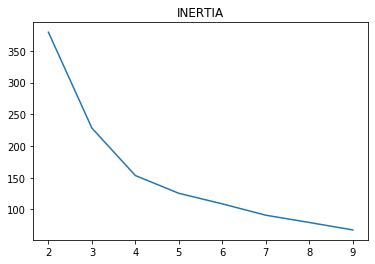

In [57]:
plt.plot([i for i in range(2,10)],inertia_arr)
plt.title('INERTIA');

In [58]:
model=AgglomerativeClustering(n_clusters=5)

In [59]:
train['cluster_Social']=model.fit_predict(train_scaled)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'TRAIN')

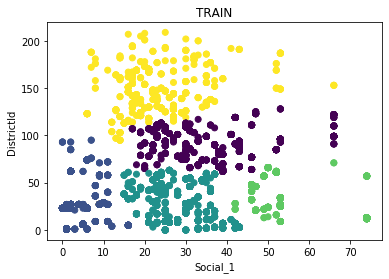

In [60]:
plt.scatter(train['Social_1'],train['DistrictId'],c=train['cluster_Social'])
plt.xlabel('Social_1')
plt.ylabel('DistrictId')
plt.title('TRAIN')

In [61]:
knn=KNeighborsClassifier(n_neighbors=5)

In [62]:
%%time
knn.fit(train_scaled,train['cluster_Social'])

Wall time: 4 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [63]:
valid_scaled=scaler.transform(valid.loc[:,['Social_1','DistrictId']])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


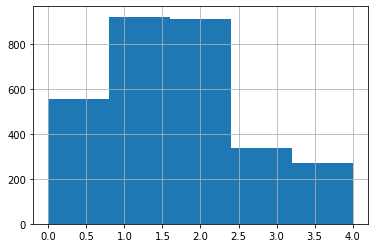

In [64]:
valid['cluster_Social']=knn.predict(valid_scaled)
valid.cluster_Social.hist(bins=5)

In [66]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2994 entries, 1254 to 9624
Data columns (total 24 columns):
Id                2994 non-null int64
DistrictId        2994 non-null int64
Rooms             2994 non-null float64
Square            2994 non-null float64
LifeSquare        2994 non-null float64
KitchenSquare     2994 non-null float64
Floor             2994 non-null int64
HouseFloor        2994 non-null float64
HouseYear         2994 non-null int64
Ecology_1         2994 non-null float64
Social_1          2994 non-null int64
Social_2          2994 non-null int64
Social_3          2994 non-null int64
Healthcare_1      2994 non-null float64
Helthcare_2       2994 non-null int64
Shops_1           2994 non-null int64
Price             2994 non-null float64
Ecology_2_A       2994 non-null uint8
Ecology_2_B       2994 non-null uint8
Ecology_3_A       2994 non-null uint8
Ecology_3_B       2994 non-null uint8
Shops_2_A         2994 non-null uint8
Shops_2_B         2994 non-null uint8


### Кластеризация по 'Helthcare_2','DistrictId'

In [67]:
train_scaled=scaler.fit_transform(train.loc[:,['Helthcare_2','DistrictId']])
train_scaled

array([[0.83333333, 0.74641148],
       [0.        , 0.00478469],
       [0.        , 0.11004785],
       ...,
       [0.        , 0.02870813],
       [0.        , 0.1291866 ],
       [0.16666667, 0.25358852]])

In [68]:
inertia_arr=[]
for i in range(2,10):
    temp_model=KMeans(n_clusters=i,random_state=42)
    temp_model.fit(train_scaled)
    temp_inertia=temp_model.inertia_
    print(temp_inertia)
    inertia_arr.append(temp_inertia)

363.1408579477878
245.184243228565
181.53101433558265
139.20793285529845
112.98567225066111
96.40233835742872
82.39571388252317
71.65612602921013


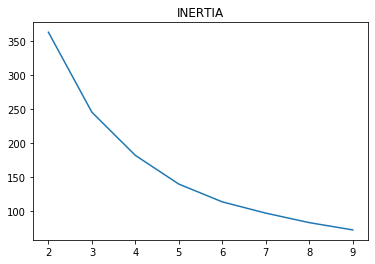

In [69]:
plt.plot([i for i in range(2,10)],inertia_arr)
plt.title('INERTIA');

In [70]:
model=AgglomerativeClustering(n_clusters=5)

In [71]:
train['cluster_Helthcare']=model.fit_predict(train_scaled)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'TRAIN')

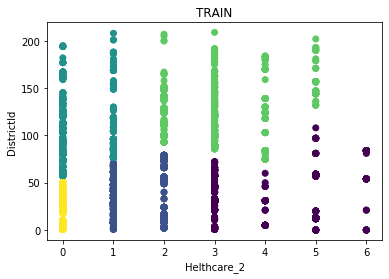

In [72]:
plt.scatter(train['Helthcare_2'],train['DistrictId'],c=train['cluster_Helthcare'])
plt.xlabel('Helthcare_2')
plt.ylabel('DistrictId')
plt.title('TRAIN')

In [73]:
knn=KNeighborsClassifier(n_neighbors=5)

In [74]:
%%time
knn.fit(train_scaled,train['cluster_Helthcare'])

Wall time: 9 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [75]:
valid_scaled=scaler.transform(valid.loc[:,['Helthcare_2','DistrictId']])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


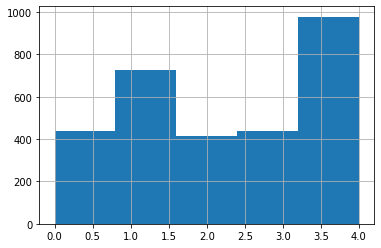

In [76]:
valid['cluster_Helthcare']=knn.predict(valid_scaled)
valid.cluster_Helthcare.hist(bins=5)

In [78]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2994 entries, 1254 to 9624
Data columns (total 25 columns):
Id                   2994 non-null int64
DistrictId           2994 non-null int64
Rooms                2994 non-null float64
Square               2994 non-null float64
LifeSquare           2994 non-null float64
KitchenSquare        2994 non-null float64
Floor                2994 non-null int64
HouseFloor           2994 non-null float64
HouseYear            2994 non-null int64
Ecology_1            2994 non-null float64
Social_1             2994 non-null int64
Social_2             2994 non-null int64
Social_3             2994 non-null int64
Healthcare_1         2994 non-null float64
Helthcare_2          2994 non-null int64
Shops_1              2994 non-null int64
Price                2994 non-null float64
Ecology_2_A          2994 non-null uint8
Ecology_2_B          2994 non-null uint8
Ecology_3_A          2994 non-null uint8
Ecology_3_B          2994 non-null uint8
Shops_2_A    

### Кластеризация по 'Shops_1','DistrictId'

In [79]:
train_scaled= scaler.fit_transform(train.loc[:,[ 'Shops_1','DistrictId']])
train_scaled

array([[0.30434783, 0.74641148],
       [0.04347826, 0.00478469],
       [0.        , 0.11004785],
       ...,
       [0.        , 0.02870813],
       [0.04347826, 0.1291866 ],
       [0.13043478, 0.25358852]])

In [80]:
inertia_arr=[]
for i in range(2,10):
    temp_model=KMeans(n_clusters=i,random_state=42)
    temp_model.fit(train_scaled)
    temp_inertia=temp_model.inertia_
    print(temp_inertia)
    inertia_arr.append(temp_inertia)

354.9685793335957
198.69525769704552
150.54761128373485
117.8557073365473
102.21689688821743
84.14740032038621
70.21180600579542
62.00568151607853


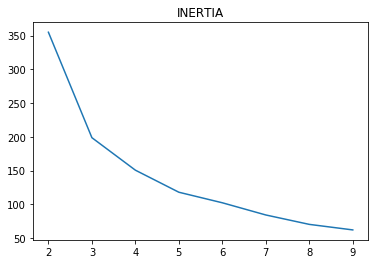

In [81]:
plt.plot([i for i in range(2,10)],inertia_arr)
plt.title('INERTIA');

In [82]:
model=AgglomerativeClustering(n_clusters=5)

In [83]:
train['cluster_Shop']=model.fit_predict(train_scaled)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'TRAIN')

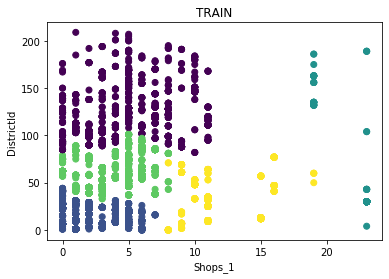

In [84]:
plt.scatter(train['Shops_1'],train['DistrictId'],c=train['cluster_Shop'])
plt.xlabel('Shops_1')
plt.ylabel('DistrictId')
plt.title('TRAIN')

In [85]:
knn=KNeighborsClassifier(n_neighbors=5)

In [86]:
%%time
knn.fit(train_scaled,train['cluster_Shop'])

Wall time: 4 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [87]:
valid_scaled=scaler.transform(valid.loc[:,['Shops_1','DistrictId']])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


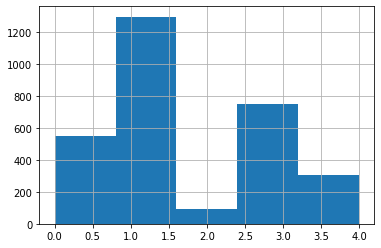

In [88]:
valid['cluster_Shop']=knn.predict(valid_scaled)
valid.cluster_Shop.hist(bins=5)

In [90]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2994 entries, 1254 to 9624
Data columns (total 26 columns):
Id                   2994 non-null int64
DistrictId           2994 non-null int64
Rooms                2994 non-null float64
Square               2994 non-null float64
LifeSquare           2994 non-null float64
KitchenSquare        2994 non-null float64
Floor                2994 non-null int64
HouseFloor           2994 non-null float64
HouseYear            2994 non-null int64
Ecology_1            2994 non-null float64
Social_1             2994 non-null int64
Social_2             2994 non-null int64
Social_3             2994 non-null int64
Healthcare_1         2994 non-null float64
Helthcare_2          2994 non-null int64
Shops_1              2994 non-null int64
Price                2994 non-null float64
Ecology_2_A          2994 non-null uint8
Ecology_2_B          2994 non-null uint8
Ecology_3_A          2994 non-null uint8
Ecology_3_B          2994 non-null uint8
Shops_2_A    

In [91]:
train['price_by'] = train['Price']/train['Square'].mean()
train['price_by'].head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1778    2934.798565
6061    3360.095701
752     1624.652917
9720    1596.584091
4024    3246.990624
Name: price_by, dtype: float64

In [92]:
price_mean_by_square=train.groupby(['DistrictId'],as_index=False).agg({'price_by':'mean'}).rename(columns={'price_by':'price_mean_by_square'})

In [93]:
price_mean_by_square.head()

,DistrictId,price_mean_by_square
0,0,3451.269114
1,1,3331.166033
2,2,4285.299821
3,3,3142.473908
4,4,4869.656405


In [94]:
price=(train['Price']/train['Square']).mean()
price

3894.472033495208

In [95]:
price_mean_by_distr_rooms=train.groupby(['DistrictId','Rooms'],as_index=False).agg({'price_by':'mean'}).rename(columns={'price_by':'mean_price_by_dr'})
price_mean_by_distr_rooms.head()

,DistrictId,Rooms,mean_price_by_dr
0,0,1.0,2604.132930
1,0,2.0,3671.486563
2,0,3.0,4778.512402
3,1,1.0,2639.475902
4,1,2.0,3533.586920


In [98]:
def add_mean_price(df,price_mean_by_distr_rooms,price_mean_by_square,price):
    df=pd.merge(df,price_mean_by_distr_rooms,on=['DistrictId','Rooms'],how='left')
    df=pd.merge(df,price_mean_by_square,on='DistrictId',how='left')
    df['mean_price_by_dr']=df['mean_price_by_dr'].fillna(df['price_mean_by_square'])
    df['mean_price_by_dr']=df['mean_price_by_dr'].fillna(price)
    df['price_mean_by_square']=df['price_mean_by_square'].fillna(price)
    return df    

In [99]:
train = add_mean_price(train,price_mean_by_distr_rooms,price_mean_by_square,price)

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6986 entries, 0 to 6985
Data columns (total 41 columns):
Id                      6986 non-null int64
DistrictId              6986 non-null int64
Rooms                   6986 non-null float64
Square                  6986 non-null float64
LifeSquare              6986 non-null float64
KitchenSquare           6986 non-null float64
Floor                   6986 non-null int64
HouseFloor              6986 non-null float64
HouseYear               6986 non-null int64
Ecology_1               6986 non-null float64
Social_1                6986 non-null int64
Social_2                6986 non-null int64
Social_3                6986 non-null int64
Healthcare_1            6986 non-null float64
Helthcare_2             6986 non-null int64
Shops_1                 6986 non-null int64
Price                   6986 non-null float64
Ecology_2_A             6986 non-null uint8
Ecology_2_B             6986 non-null uint8
Ecology_3_A             6986 non-null uin

In [101]:
def dummies1(df,cluster_Social='cluster_Social', cluster_Helthcare='cluster_Helthcare', cluster_Shop = 'cluster_Shop' ):
    df[cluster_Social]=df[cluster_Social].astype(object)
    df[cluster_Helthcare]=df[cluster_Helthcare].astype(object)
    df[cluster_Shop]=df[cluster_Shop].astype(object)
    df=pd.get_dummies(df)
    return df

In [102]:
train = dummies1(train)

In [104]:
valid = add_mean_price(valid,price_mean_by_distr_rooms,price_mean_by_square,price)
valid=dummies1(valid)

In [105]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2994 entries, 0 to 2993
Data columns (total 40 columns):
Id                      2994 non-null int64
DistrictId              2994 non-null int64
Rooms                   2994 non-null float64
Square                  2994 non-null float64
LifeSquare              2994 non-null float64
KitchenSquare           2994 non-null float64
Floor                   2994 non-null int64
HouseFloor              2994 non-null float64
HouseYear               2994 non-null int64
Ecology_1               2994 non-null float64
Social_1                2994 non-null int64
Social_2                2994 non-null int64
Social_3                2994 non-null int64
Healthcare_1            2994 non-null float64
Helthcare_2             2994 non-null int64
Shops_1                 2994 non-null int64
Price                   2994 non-null float64
Ecology_2_A             2994 non-null uint8
Ecology_2_B             2994 non-null uint8
Ecology_3_A             2994 non-null uin

In [106]:
feats6 = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
       'Shops_2_B', 'price_mean_by_square','cluster_Social_0', 'cluster_Social_1', 'cluster_Social_2',
       'cluster_Social_3', 'cluster_Social_4']

In [108]:
params={
        'min_samples_leaf':[3,5,7,10],
        'n_estimators':[25,50,75, 100],
        'max_depth':[3,5,7]    
        }
regr=GridSearchCV(RF(),param_grid=params,cv=3)

In [109]:
%%time
regr.fit(train.loc[:,feats6],train['Price'])

Wall time: 1min 31s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7],
       

In [110]:
regr.best_params_

{'max_depth': 7, 'min_samples_leaf': 7, 'n_estimators': 75}

In [111]:
regr.best_score_

0.7296241139511834

In [112]:
model=RF(n_estimators=75,max_depth=7,min_samples_leaf=7)

In [113]:
model.fit(train.loc[:,feats6],train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [115]:
for i,j in zip(feats6, model.feature_importances_):
    print(i,j)

Rooms 0.02957561752283253
Square 0.49716216083562287
LifeSquare 0.005878774703385318
KitchenSquare 0.012324203687898954
Floor 0.004777366338173906
HouseFloor 0.0069565481427251285
HouseYear 0.007267204435745749
Ecology_1 0.00444821122100659
Social_1 0.018094228319741234
Social_2 0.015949733672564238
Social_3 0.013896978313563735
Healthcare_1 0.0038510119439945714
Helthcare_2 0.0014805704312704554
Shops_1 0.003243819915721099
Ecology_2_A 0.0
Ecology_2_B 0.0
Ecology_3_A 0.0
Ecology_3_B 0.0
Shops_2_A 0.00011207373402558807
Shops_2_B 0.00011033563260990213
price_mean_by_square 0.3700869910389732
cluster_Social_0 0.0004633196832327167
cluster_Social_1 0.0032823530043678043
cluster_Social_2 0.0007725298414602522
cluster_Social_3 6.0120567133369645e-05
cluster_Social_4 0.00020584701395085541


In [116]:
y_pred=model.predict(valid.loc[:,feats6])

In [117]:
r2(valid['Price'],y_pred)

0.7218835473380856

In [128]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 37 columns):
Id                      5000 non-null int64
DistrictId              5000 non-null int64
Rooms                   5000 non-null float64
Square                  5000 non-null float64
LifeSquare              5000 non-null float64
KitchenSquare           5000 non-null float64
Floor                   5000 non-null int64
HouseFloor              5000 non-null float64
HouseYear               5000 non-null int64
Ecology_1               5000 non-null float64
Social_1                5000 non-null int64
Social_2                5000 non-null int64
Social_3                5000 non-null int64
Healthcare_1            5000 non-null float64
Helthcare_2             5000 non-null int64
Shops_1                 5000 non-null int64
Ecology_2_A             5000 non-null uint8
Ecology_2_B             5000 non-null uint8
Ecology_3_A             5000 non-null uint8
Ecology_3_B             5000 non-null uint8

In [119]:
test['Healthcare_1']=test['Healthcare_1'].fillna(test['Healthcare_1'].median())
square_lifesquare=(test.Square/test.LifeSquare).mean()
test['LifeSquare']=test.LifeSquare.fillna(test['Square']/square_lifesquare)

In [121]:
test= dummies(test, ['Ecology_2', 'Ecology_3', 'Shops_2'])

In [123]:
test_scaled=scaler.transform(test.loc[:,['Social_1','DistrictId']])
test['cluster_Social']=knn.predict(test_scaled)
test_scaled=scaler.transform(test.loc[:,['Helthcare_2','DistrictId']])
test['cluster_Helthcare']=knn.predict(test_scaled)
test_scaled=scaler.transform(test.loc[:,['Shops_1','DistrictId']])
test['cluster_Shop']=knn.predict(test_scaled)

In [125]:
test = dummies1(test)

In [127]:
test = add_mean_price(test,price_mean_by_distr_rooms,price_mean_by_square,price)

In [129]:
test['Price']=model.predict(test.loc[:,feats6])

In [131]:
test.loc[:,['Id','Price']].to_csv('MGebekov_predictions_.csv',index=False)

In [132]:
pd.read_csv('MGebekov_predictions_.csv')

,Id,Price
0,725,156067.731703
1,15856,235133.293962
2,5480,276605.938451
3,15664,309204.755056
4,14275,129155.562214
5,7633,199392.014490
6,13329,170003.282824
7,5502,203227.446359
8,4220,314959.556950
9,11538,212066.726385
